# 多项式拟合策略

## 摘要

## 理论模型

在金融市场中, 证券价格的变化通常由随机噪声和趋势构成. 在没有任何信息的情况下, 证券价格的表现一般可以认为是布朗运动, 不可以被预测. 当消息出现时, 价格出现趋势变动, 此时可以如果可以捕获这种趋势, 从而顺势交易获利. 

趋势的识别有很多方法, 这里通过函数拟合来研究, 其中最常用的方法有多项式回归、傅立叶展开等.

多项式拟合, 即给定数据点序列: ${(t, p(t))}_t$, 依据最小二乘法(OLS)进行多项式回归, n 阶多项式回归函数的形式为:
$$
f(t) = \sum\limits_{i=0}^{n}a_i t^{n-i} = a_0t^n + a_{1}t^{n-1} + \cdots + a_{n-1}t + a_n
$$
这里可以简单的认为 t 为时间, p(t) 为 t 时刻的证券价格, $a_i,i=0,1,\ldots,n$ 为回归系数. 最小二乘法即使得回归函数值与原始值之间偏差的平方和最小:
$$
\min\limits_{a_i} \sum\limits_t \left(p(t)-f(t)\right)^2
$$

数学上, 导数可以反映函数局部变化的特征. 比如一阶导数反映趋势的方向和强弱, 即价格变化的"速度", 而二阶导数进一步反映趋势变化的快慢, 即价格变化的"加速度". 对回归函数求一、二阶导数, 通过导数值可以对当前趋势的方向、力度以及变化进行判断. 一阶导数大于零表示具有上升趋势, 若二阶导数也大于零, 则体现为加速上升, 反之则为上升趋势放缓. 一阶导数小于零表示下降趋势, 若二阶导数也小于零, 则体现为加速下降, 反之则为下降趋势放缓. 

综合考虑, 可以简单的按照一二阶导数的符号构建趋势跟踪策略, 即在趋势加速上升时做多, 在趋势加速下降时做空, 而在趋势放缓时清仓, 具体为:

| 交易信号 | 一阶导数>0 | 一阶导数<0 |
| -------- | ---------- | ---------- |
| **二阶导数>0** | 加速上升, 做多 | 下降放缓, 平仓 |
| **二阶导数<0** | 上升放缓, 平仓 | 加速下降, 做空 |


## 实证分析

策略有三个主要参数需要确定:
* 多项式阶数: 由于需要一二阶导数, 为了避免平凡解, 多项式阶数至少为 2.
* 回归开始时间: 进行函数拟合的开始时间, 以此时间至当前时间的价格数据进行回归
* 交易开始时间: 在此之前, 等待趋势形成, 并不做任何交易.

![多项式拟合策略图示](./images/多项式拟合策略图示.png)

开盘后一段时间内的行情对于当日趋势的判断很重要, 2016 年以前, 股指期货 9:15 开盘, 早于股票市场 15 分钟, 这 15 分钟不利于趋势的判断, 所以回归开始时间应该晚于开盘时间. 趋势的形成和确认通常需要一定的时间, 所以设定一个交
易开始时间, 在此时间之后才进行趋势的判断和交易. 此时, 首先进行函数回归, 并计算当前时点的一阶和二阶导数值, 得到交易信号. 随着时间的推移, 新的信息进入回归样本, 回归得到的函数也动态变化, 交易信号也随之变化. 最后收盘前予以平仓了结.

由于 2016 年 1 月 1 日中金所调整了股指期货的交易时间, 所以 2016 年之前和之后分两段来单独调参并验证策略. 2016 年以前有近 6 年的数据, 以前 3 年的数据(2010-4-16 至 2013-4-15)作为样本优化参数, 确定多项式的阶数, 回归开始时间和交易开始时间. 以剩下的数据(2013-4-16 至 2015-12-31)作为样本外对策略进行验证. 2016 年以后至今(2018-11-30)有近三年的数据, 以前一年半的数据(2016-1-1 至 2017-6-30)作为样本优化参数, 确定新的多项式阶数, 回归开始时间和交易开始时间, 以剩余的数据(2017-7-1 至 2018-11-30)作为样本外对策略进行验证. 数据为频率 1 分钟的沪深 300 股指期货主力合约分时数据. 模拟交易以卖一价开多仓和平空仓, 以买一价开空仓和平多仓, 双边手续费率为万分之 0.8, 仅作日内交易, 不持仓过夜, 收盘最后一分钟平仓了结所有仓位. 暂不考虑股指期货的杠杆.

由于策略回测的时间较长, 这里的参数优化非全局搜索, 首先固定两个参数, 然后搜索另一个参数.

首先导入需要的包并定义策略.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

import QuantStudio.api as QS

In [2]:
%%writefile PolyfitStrategy.py
# coding=utf-8
import datetime as dt

import numpy as np
import pandas as pd

import QuantStudio.api as QS

class PolyfitStrategy(QS.BackTest.Strategy.TimingStrategy):
    def init(self):
        self.UserData["RegressDTs"] = []# 回归样本时间序列
    def genSignal(self, idt, trading_record):
        TargetID = self.ModelArgs["TargetID"]
        if idt.time()>self.ModelArgs["清仓时间"]:# 进入清仓时段
            self.UserData["RegressDTs"] = []
            return pd.Series(0.0, index=[TargetID])
        if idt.time()>=self.ModelArgs["回归开始时间"]:# 进入回归区间
            self.UserData["RegressDTs"].append(idt)
        if idt.time()>=self.ModelArgs["交易开始时间"]:# 进入交易区间, 进行多项式拟合
            Price = self.MainFactorTable.readData(factor_names=["最新价"], ids=[TargetID], dts=self.UserData["RegressDTs"][:-1]).iloc[0, :, 0]
            Coefs = np.polyfit(np.arange(0, Price.shape[0]), Price.values, deg=self.ModelArgs["多项式阶数"])
            d1 = np.polyval(np.polyder(Coefs, m=1), Price.shape[0])# 一阶导数值
            d2 = np.polyval(np.polyder(Coefs, m=2), Price.shape[0])# 二阶导数值
            PositionNum = self["目标账户"].PositionNum.loc[TargetID]
            if PositionNum==0:
                if (d1>0) and (d2>0): return pd.Series(1.0, index=[TargetID])
                elif (d1<0) and (d2<0): return pd.Series(-1.0, index=[TargetID])
                else: return None
            elif PositionNum<0:
                if (d1>0) and (d2>0): return pd.Series(1.0, index=[TargetID])
                elif (d1>0) or ((d1<0) and (d2>0)): return pd.Series(0.0, index=[TargetID])
                else: return None
            else:
                if (d1<0) and (d2<0): return pd.Series(-1.0, index=[TargetID])
                elif (d1<0) or ((d1>0) and (d2<0)): return pd.Series(0.0, index=[TargetID])
                else: return None

Overwriting PolyfitStrategy.py


### 多项式阶数

固定回归开始时间为 9:45, 交易开始时间为 11:10, 多项式阶数分别取 2, 3, 4, 5, 6, 7, 8, 下面是样本内策略的表现:

==========历史回测==========
1. 初始化
耗时 : 16.83
2. 循环计算


100% (588060 of 588060) |#################| Elapsed Time: 4:59:11 Time: 4:59:11


耗时 : 17951.03
3. 结果生成
耗时 : 18.24
总耗时 : 17986.10


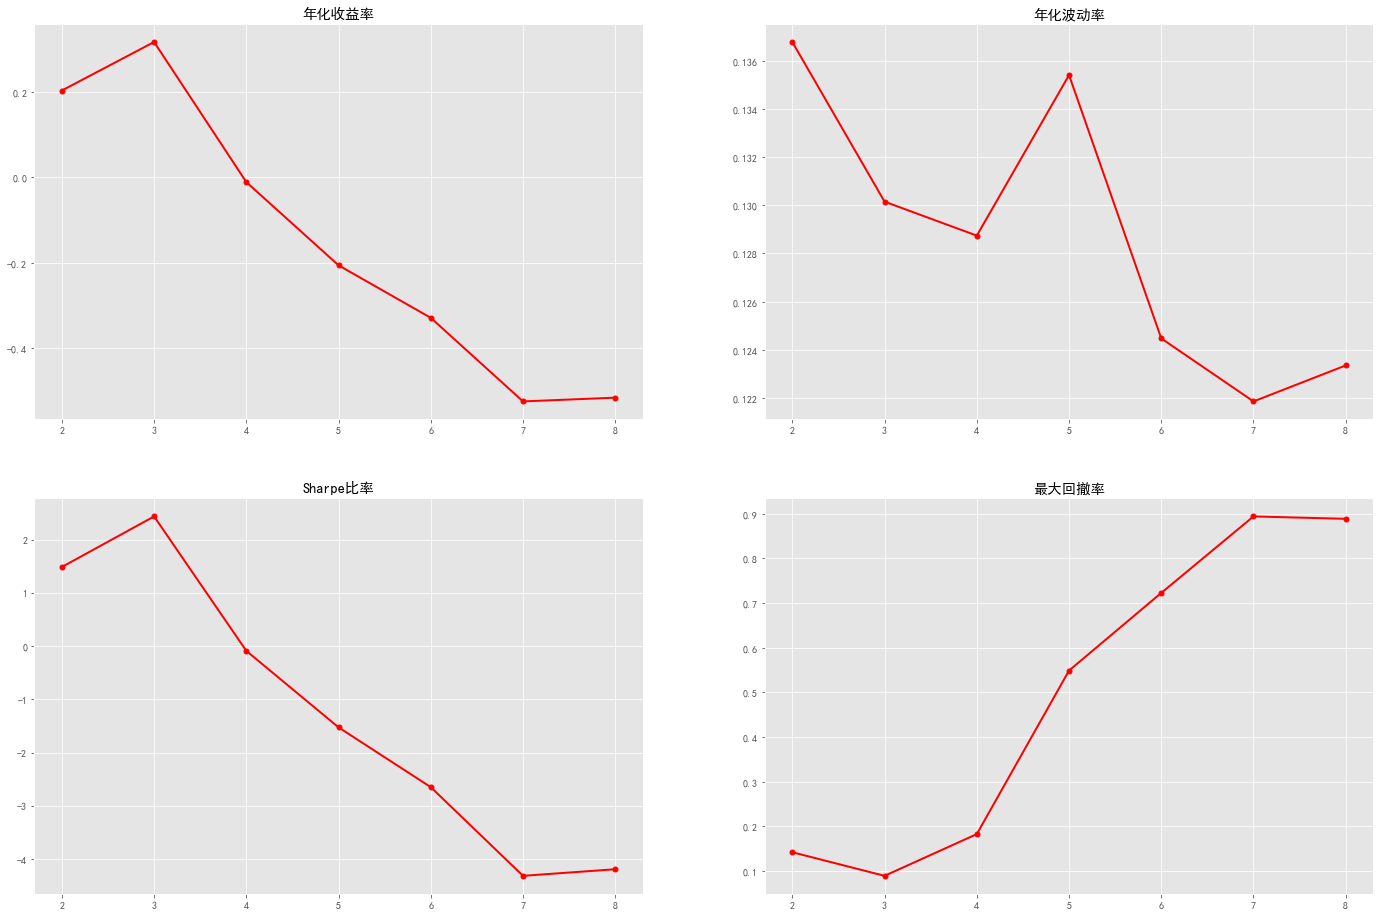

In [3]:
from PolyfitStrategy import PolyfitStrategy


if __name__=='__main__':
    # 创建因子库
    ADB = QS.FactorDB.ArcticDB()
    ADB.connect()
    
    # 创建因子表
    FT = ADB.getTable("MinuteBar")
    DTs = FT.getDateTime(ifactor_name="最新价", iid="IF00", start_dt=dt.datetime(2010, 4, 16), end_dt=dt.datetime(2013, 4, 15, 16))
    IDs = ["IF00"]
    CFT = QS.FactorDB.CustomFT(name="CFT")
    CFT.addFactors(factor_table=FT, factor_names=["最新价", "买一价", "卖一价"])
    CFT.setDateTime(DTs)
    CFT.setID(IDs)
    CFT["遍历模式"]["缓冲模式"] = "ID"
    CFT["遍历模式"]["向后缓冲时点数"] = 240
    
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    
    Degree = np.arange(2, 9)
    for iDeg in Degree:
        iAccount = QS.BackTest.Strategy.DefaultAccount(market_ft=CFT)
        iAccount["初始资金"] = 1e8
        iAccount["负债上限"] = 0.0
        iAccount["交易延迟"] = False
        iAccount["目标ID"] = IDs
        iAccount["买入限制"]["成交价"] = "卖一价"
        iAccount["买入限制"]["交易费率"] = 0.00008
        iAccount["卖出限制"]["成交价"] = "买一价"
        iAccount["卖出限制"]["交易费率"9] = 0.00008
        iAccount["卖出限制"]["允许卖空"] = True
        iAccount["最新价"] = "最新价"
        iModule = PolyfitStrategy(name="多项式拟合策略", factor_table=CFT)
        iModule["目标账户"] = iAccount
        iModule["资金分配"] = pd.Series(iAccount["初始资金"]/len(IDs), index=IDs)
        iModule.ModelArgs["TargetID"] = "IF00"
        iModule.ModelArgs["多项式阶数"] = iDeg
        iModule.ModelArgs["回归开始时间"] = dt.time(9, 45)
        iModule.ModelArgs["交易开始时间"] = dt.time(11, 10)
        iModule.ModelArgs["清仓时间"] = dt.time(15, 14)
        Model.Modules.append(iModule)
    
    # 运行模型
    Model.run(dts=DTs, subprocess_num=3)
    
    # 查看结果
    Output = Model.output()
    Output["参数遍历"] = {Degree[i]:Output[str(i)+"-多项式拟合策略"]["Strategy"]["统计数据"]["无杠杆表现"].loc[["年化收益率", "年化波动率", "Sharpe比率", "最大回撤率"]] for i in range(Degree.shape[0])}
    Output["参数遍历"] = pd.DataFrame(Output["参数遍历"]).T.sort_index()
    QS.Tools.QtGUI.showOutput(Output)